In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## READ TEST DATASET

**Please modify the file directory in the code below for reading the holdout test set features and labels files.**

In [2]:
df_test=pd.read_csv("ExampleTestSet/ExampleTestSet_Data.csv")

If test dataset involve multiple files, please modify below code to append a full dataframe. Ensure that the hold out test set features are written to pd DataFrame named  "df_test"

In [3]:
#df_raw0=pd.read_csv("ExampleTestSet/ExampleTestSet_Data1.csv")
#df_raw1=pd.read_csv("ExampleTestSet/ExampleTestSet_Data2.csv")
#df_raw2=pd.read_csv("ExampleTestSet/ExampleTestSet_Data3.csv")
#df_raw2=pd.read_csv("ExampleTestSet/ExampleTestSet_Data3.csv")
#df_test= df_raw0.append(df_raw1).append(df_raw2).append(df_raw3)
#remove from memory
#del df_raw0
#del df_raw1
#del df_raw2
#del df_raw3

In [4]:
labels_test=pd.read_csv("ExampleTestSet/ExampleTestSet_Label.csv")

In [5]:
display(df_test.head())
display(labels_test.head())

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,1065151889565,8.000,224.0,-0.354353,9.759064,6.476513,0.042109,0.051884,-0.016429,409.0,10.308342
2,833223655481,3.000,126.0,-2.135000,3.862000,7.854000,0.365186,-0.317739,-0.984665,10.0,0.000000
3,1211180777501,4.700,171.0,0.773069,9.062111,-0.496280,0.039235,0.019844,-0.001641,958.0,9.459939
4,1683627180179,3.573,185.0,-1.588242,9.385254,-0.961319,-0.093323,0.190567,-0.029999,506.0,3.470000


,bookingID,label
0,773094113280,0
1,1340029796375,0
2,721554505789,0
3,927712936006,0
4,1589137899542,0


## DATA CLEANING
We need to perform basic data cleaning as we did when we prepared our training dataset
### Check for Inconsistency
Make sure we address duplicate bookingID in test dataset if any

In [6]:
duplicateID=labels_test[labels_test.duplicated(['bookingID'])].bookingID
duplicateID
if len(duplicateID)>0:
    duplicateLabels=labels_test[labels_test.bookingID.isin(duplicateID)]
    display(duplicateLabels.sort_values(by=['bookingID','label']))
else:
    print('No duplicateID in labels_test')
        

No duplicateID in labels_test


Competition host can decide to remove the duplicatedID by removing them entirely, or choose to select one to keep:

In [7]:
#To remove entirely the bookingID with duplicated labels
labels_test=labels_test[-labels_test.bookingID.isin(duplicateID)]
df_test=df_test[-df_test.bookingID.isin(duplicateID)]

In [8]:
print('unique bookingID')
print('df_test:',len(df_test.bookingID.unique()))
print('labels_test:',len(labels_test.bookingID.unique()))

unique bookingID
df_test: 901
labels_test: 901


### Check for missing value

In [9]:
df_na= pd.DataFrame((df_test.isnull().sum().values),index=df_test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if df_na.loc[df_na.loc[:,'isNA']>0,:].shape[0]>1 :
    print("Features dataset")
    print(df_na.loc[df_na.loc[:,'isNA']> 0,])
else:
    print('no NA in Feature dataset')
    
labels_na= pd.DataFrame((labels_test.isnull().sum().values),index=labels_test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if labels_na.loc[labels_na.loc[:,'isNA']>0,:].shape[0]>1 :
    print("Labels dataset")
    print(labels_na.loc[labels_na.loc[:,'isNA']> 0,])
else:
    print('no NA in Labels dataset')

no NA in Feature dataset
no NA in Labels dataset


In [10]:
#Drop NA rows if there is any, and make sure df_test and labels_test have equal size of bookingID
labels_test.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)
df_test=df_test[df_test['bookingID'].isin(labels_test['bookingID'])]

We will ignore erroneous data as was in our machine learning training module. Feature engineering will take care of that. 

## FEATURE ENGINEERING
We will trim down the features to top10 features used in the final model as illustrated in the other jupyter notebook

In [11]:
uniqueBookingID=df_test.bookingID.unique()

In [12]:
#Set bookingID and second as index and sort them so seconds are in ascending order per booking ID
#This will help us avoid using groupby and sort_values which are time consuming, especially when we do it over loops. 
df_test.set_index(['bookingID','second'],inplace=True)
df_test.sort_index(inplace=True)
#Remove second from index, so we will call the data based on bookingID only
df_test.reset_index(level=1, inplace=True, col_level=3 )

In [13]:
#we will need to use sine and radian function from math module
import math


#Initialize a few objects
df_agg=pd.DataFrame()
mydict={}



#Create features by looping through every bookingID. 
#We need to take difference between subsequent rows within the under the same bookingID for most features, then aggregate them. 
for i,ID in enumerate(uniqueBookingID):

    #Progress bar to track progress
    if i%50 ==0:
        print('progress:',i,'/',len(uniqueBookingID))
    
    df_features=df_test.loc[ID]
    df_features['Time_Interval']= df_features['second']-df_features['second'].shift(1)

    
    #Vehicle decceleration
    #=================================    
    #Computed by checking for Speed now > Speed before, take the absolute value of Speed difference over time interval
    df_features['Vehicle_Deccel']= abs((df_features['Speed']<df_features['Speed'].shift(1))*(
        (df_features['Speed']-df_features['Speed'].shift(1))/df_features['Time_Interval']))
    
    
    #Device Acceleration Magnitude
    #=================================    
    #Using Pythagorean triple, compute for device acceleration magnitude
    df_features['Device_Accel'] = np.sqrt(df_features['acceleration_x']**2+df_features['acceleration_y']**2+
                                          df_features['acceleration_z']**2)
    
    
    #Rate of Bearing
    #=================================    
    #Bearing is 0 when car is stationary,we will remove stationary vehicle data since it give a erroneous computation.
    #We need to handle the data differently, so a separate dataframe is used in this computation
    df_bearing = df_features[['Speed','Bearing','Time_Interval']].copy()
    df_bearing=df_bearing[df_bearing['Speed']>0]
    df_bearing['Rate_Bearing']=abs(((df_bearing['Bearing'].apply(lambda x: math.sin(math.radians(x)))-df_bearing['Bearing'].
                                     shift(1).apply(lambda x: math.sin(math.radians(x))))/df_bearing['Time_Interval']))
    #Drop anything above (sine(90deg) = 1), as it is unrealistic.
    df_bearing=df_bearing[df_bearing['Rate_Bearing']<1]

    
    #Speed Multipliers
    #================================= 
    df_features['Speed-Vehicle_Deccel']=abs(df_features['Speed']*df_features['Vehicle_Deccel'])
    df_features['Speed-Device_Accel']=abs(df_features['Speed']*df_features['Device_Accel'])

    
    
    #2D-Plane Acceleration Magnitude
    #================================= 
    df_features['yz_Device_Accel']=np.sqrt((df_features['acceleration_y']**2)*(df_features['acceleration_z']**2))
    
    
    #Convert Gyro to Absolute value
    #================================= 
    df_features['gyro_y']=abs(df_features['gyro_y'])
    df_features['gyro_z']=abs(df_features['gyro_z'])    
    
    
    
    #Replace NaN with 0. NaN is a result of the shift function. Any NaN value can be safely replaced by 0.
    df_features.fillna(0)
    
    #Save bookingID to dict.
    mydict['bookingID']=ID
    
    #Top1 Feature
    mydict['Rate_Bearing-max']=df_bearing['Rate_Bearing'].agg('max')
    #Top2 Feature
    mydict['Speed-Vehicle_Deccel-max']=df_features[df_features['Vehicle_Deccel']>0.5]['Speed-Vehicle_Deccel'].agg('max')
    #Top3 Feature
    mydict['Speed-Device_Accel-mean']=df_features[df_features['Speed']>0]['Speed-Device_Accel'].agg('mean')
    #Top4 Feature
    mydict['gyro_y-max']=df_features['gyro_y'].agg('max')
    #Top5 Feature
    mydict['Device_Accel-std']=df_features[df_features['Speed']>0]['Device_Accel'].agg('std')
    #Top6 Feature
    mydict['Rate_Bearing-std']=df_bearing['Rate_Bearing'].agg('std')    
    #Top7 Feature
    mydict['yz_Device_Accel-max']=df_features['yz_Device_Accel'].agg('max')    
    #Top8 Feature
    mydict['Speed-Device_Accel-max']=df_features[df_features['Speed']>0]['Speed-Device_Accel'].agg('max')
    #Top2 Feature
    mydict['Speed-Vehicle_Deccel-mean']=df_features[df_features['Vehicle_Deccel']>0.5]['Speed-Vehicle_Deccel'].agg('mean')
    #Top4 Feature
    mydict['gyro_z-std']=df_features['gyro_z'].agg('std')

    df_agg=df_agg.append(mydict,ignore_index=True)    
    

print('progress:',i+1,'/',len(uniqueBookingID),'DONE')

progress: 0 / 901
progress: 50 / 901
progress: 100 / 901
progress: 150 / 901
progress: 200 / 901
progress: 250 / 901
progress: 300 / 901
progress: 350 / 901
progress: 400 / 901
progress: 450 / 901
progress: 500 / 901
progress: 550 / 901
progress: 600 / 901
progress: 650 / 901
progress: 700 / 901
progress: 750 / 901
progress: 800 / 901
progress: 850 / 901
progress: 900 / 901
progress: 901 / 901 DONE


### Preprocessing Data for Machine Learning
Using Robust Scaler for data normalization as we did for our training set

In [14]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
df_agg_scaled = scaler.fit_transform(df_agg)
df_agg_scaled = pd.DataFrame(df_agg, columns=df_agg.columns)
df_agg_scaled['bookingID']=pd.to_numeric(df_agg['bookingID'],downcast='signed')
df_agg_scaled.head(10)

,Device_Accel-std,Rate_Bearing-max,Rate_Bearing-std,Speed-Device_Accel-max,Speed-Device_Accel-mean,Speed-Vehicle_Deccel-max,Speed-Vehicle_Deccel-mean,bookingID,gyro_y-max,gyro_z-std,yz_Device_Accel-max
0,0.708672,0.759694,0.082841,222.330841,86.836341,37.858215,7.512580,1202590843006,0.892771,0.039908,67.737684
1,1.219452,0.474883,0.056263,310.655410,152.828681,52.290209,11.509422,1065151889565,0.810046,0.046827,117.955290
2,0.913431,0.996940,0.067149,351.631052,174.259333,44.272142,9.046797,833223655481,2.179927,0.128287,74.117892
3,0.482243,0.838671,0.059654,260.245242,104.928429,38.432344,8.340140,1211180777501,0.745709,0.016733,45.315252
4,0.992677,0.424852,0.039029,381.933244,167.039973,54.355500,11.039232,1683627180179,0.512268,0.023265,95.259883
5,0.522757,0.398356,0.050114,328.720787,150.562313,21.571200,8.311932,51539607586,0.486694,0.016660,67.513887
6,1.056481,0.548174,0.053711,427.086148,179.628040,63.685516,18.749364,429496729692,0.709390,0.062943,89.271262
7,0.881465,0.805463,0.079983,375.926500,133.446997,27.817096,7.157798,94489280692,0.857074,0.018357,85.991259
8,0.595386,0.603498,0.065764,225.074241,101.012976,26.379600,7.226543,558345748600,0.582169,0.021768,56.440356
9,0.725880,0.545166,0.054162,297.534192,123.759304,40.263366,11.675759,1511828488338,2.186202,0.048235,73.146957


Merge feature dataset with label so we can allign their index as we define X and y sets.

In [15]:
#merge features with label
df_agg_scaled=pd.merge(df_agg,labels_test,on='bookingID')

#set bookingID as index
df_agg_scaled.set_index('bookingID',inplace=True)

#remove any rows with NaN due to aggregation during feature engineering
#Usually these are the ones with Speed all = -1
print("bookingID",df_agg_scaled[df_agg_scaled.isna().any(axis=1)].index.values,
      "have NaN after feature engineering, and had been removed.")
df_agg_scaled.dropna(axis=0, how='any', inplace=True)

bookingID [438086664198] have NaN after feature engineering, and had been removed.


In [16]:
X_test = df_agg_scaled.drop(columns=['label'])
y_test = df_agg_scaled['label']

Reorder the columns correctly as the model only evaluate column based on positional index, not column name.

In [17]:
col_order=['Rate_Bearing-max','Speed-Vehicle_Deccel-max','Speed-Device_Accel-mean','gyro_y-max','Device_Accel-std',
           'Rate_Bearing-std','yz_Device_Accel-max','Speed-Device_Accel-max','Speed-Vehicle_Deccel-mean','gyro_z-std']
X_test=X_test[col_order]

## MACHINE LEARNING
First initialize a few modules

In [18]:
import lightgbm as lgb
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,roc_auc_score,precision_recall_curve,average_precision_score
import time

auc=pd.DataFrame()
avg_precision=pd.DataFrame()
runtime=pd.DataFrame()


Setup a function for plotting : <br>
1) Receiver Operating Characteristic (ROC)<br>
2) Precision-Recall curve (PRC)

In [19]:
def plot_ROC_PRC(false_positive_rate, true_positive_rate,recall, precision):
        # Plot ROC curves
        fig= plt.figure(figsize=(15,8))
        ax1=fig.add_subplot(1,2,1)    
        ax1.set_title('Receiver Operating Characteristic')
        ax1.plot(false_positive_rate, true_positive_rate)
        ax1.plot([0, 1], ls="--")
        ax1.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
        ax1.set_ylabel('True Positive Rate')
        ax1.set_xlabel('False Positive Rate')
        
        # Plot PRC curves
        ax2=fig.add_subplot(1,2,2)    
        ax2.set_title('Precision-Recall curve')
        ax2.plot(recall, precision)
        ax2.plot([0, 0], [1,0] , c=".7"), plt.plot([0,0] , c=".7")
        ax2.set_ylabel('Precision')
        ax2.set_xlabel('Recall')
        plt.show()

We will import our trained light gradient boosting model from before. 

In [20]:
import pickle
Trained_Model_LGB = pickle.load(open('Trained_Model/Trained_Model_LGB.sav', 'rb'))
Trained_Model_LGB

LGBMClassifier(boosting_type='goss', class_weight={0: 1, 1: 2.6},
        colsample_bytree=1.0, importance_type='gain', learning_rate=0.0012,
        max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=3, n_estimators=5000,
        n_jobs=4, num_leaves=13, objective='binary', random_state=123,
        reg_alpha=0.6, reg_lambda=0.84, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)


Light Gradient Boosting: 
roc_auc_score:  0.6934371832085582
Average Precision:  0.48486341510752917
Computation Time:  0.15 s

Confusion Matrix:
 [[509 150]
 [129 112]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78       659
           1       0.43      0.46      0.45       241

   micro avg       0.69      0.69      0.69       900
   macro avg       0.61      0.62      0.62       900
weighted avg       0.70      0.69      0.69       900



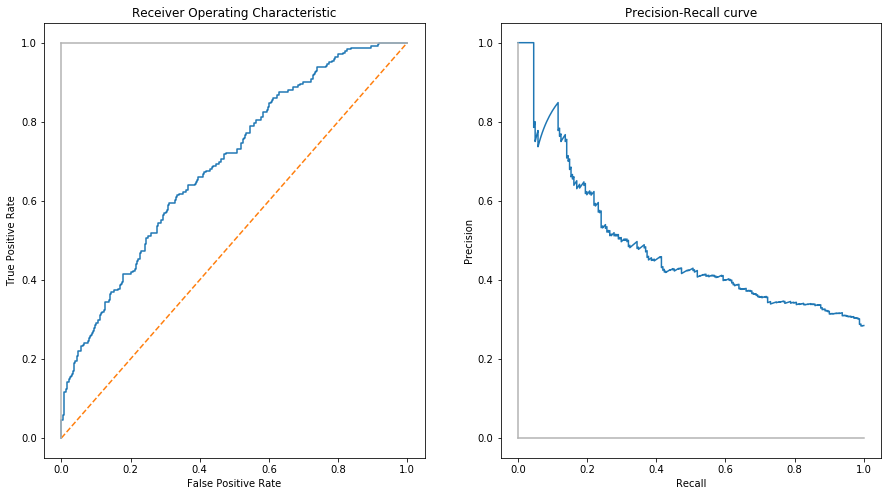

In [21]:
start = time.time()
y_pred_lgb=Trained_Model_LGB.predict(X_test) 
y_score_lgb=Trained_Model_LGB.predict_proba(X_test)[:,1] 
end = time.time()
runtime_lgb = round(end - start,2)


confusion=confusion_matrix(y_test, y_pred_lgb)
false_positive_rate_lgb, true_positive_rate_lgb, threshold = roc_curve(y_test, y_score_lgb)
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_score_lgb)

auc_lgb=roc_auc_score(y_test, y_score_lgb)
avg_precision_lgb=average_precision_score(y_test, y_score_lgb)
print('\nLight Gradient Boosting: \nroc_auc_score: ', auc_lgb)
print('Average Precision: ',avg_precision_lgb)
print('Computation Time: ', runtime_lgb ,'s')
print('\nConfusion Matrix:\n',confusion)
print('\nClassification Report:\n',classification_report(y_test,y_pred_lgb))

plot_ROC_PRC(false_positive_rate_lgb, true_positive_rate_lgb, recall_lgb, precision_lgb)